In [30]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np
import sys

import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec
import multiprocessing

from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split

from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import enchant
pd.set_option('display.max_rows', 500)

In [2]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

varcluster_info=pd.DataFrame(
{'cluster_id'  :[ '0' , '1' , '2' , '3' , '4' , '5' , '6' , '7' , '8' , '9' , '10', '11', '12', '13', '14', '15']
,'cluster_name':[ 'General' ,'Life Sciences' ,'Humanities and Social Sciences' ,'Engineering Sciences' ,'Natural Sciences' ,'Medicine' ,'Foundation & Acquisition' ,'Chemistry & Mechanical & Electrical' ,'Life Sciences' ,'Physics & Mathematical & Geometry & Analytical & Computer' ,'Eco System & Chemistry' ,'History & Cultural' ,'Climate & Earth' ,'Human & Experiment' ,'Biology & Genetics' ,'Text & Publish' ]
,'category'   :['General', 'Life Sciences', 'Humanities and Social Sciences', 'Engineering Sciences', 'Natural Sciences', 'Life Sciences', 'Uncategorized',  'Uncategorized',  'Life Sciences',  'Uncategorized' , 'Natural Sciences',  'Humanities and Social Sciences',  'Natural Sciences', 'Uncategorized', 'Uncategorized',  'General']
})

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

In [3]:
Cat_data.Category=Cat_data.Category.str.strip()

In [4]:
df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")

In [5]:
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [6]:
DescDict=[[x for x in str(i).split()] for i in df.PreProcessedDescription]
tagged_value_tags = list(create_tagged_document_based_on_tags(DescDict, df.Category.tolist()))
tagged_value = list(create_tagged_document(DescDict))

In [7]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=5, epochs=40, alpha = 0.02, dm=1, workers=multiprocessing.cpu_count())

# Build the Volabulary
model.build_vocab(tagged_value)

model.train(tagged_value, total_examples=len(tagged_value), epochs=40)

print(str(datetime.datetime.now()),'Completed')

2020-01-18 19:38:36.899208 Started
2020-01-18 19:45:50.321080 Completed


In [8]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
#model2 = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=5, epochs=40, alpha = 0.02, dm=1, workers=multiprocessing.cpu_count())

# Build the Volabulary
#model2.build_vocab(tagged_value_tags)

#model2.train(tagged_value, total_examples=len(tagged_value_tags), epochs=40)

print(str(datetime.datetime.now()),'Completed')

2020-01-18 19:45:50.471712 Started
2020-01-18 19:45:50.472039 Completed


In [9]:
modelchecked=model
target_word='environment'
print('target_word: %r model: %s similar words:' % (target_word, modelchecked))
for i, (word, sim) in enumerate(modelchecked.wv.most_similar(target_word, topn=20), 1):
    print('    %d. %.2f %r' % (i, sim, word))

target_word: 'environment' model: Doc2Vec(dm/m,d50,n5,w5,mc5,s0.001,t4) similar words:
    1. 0.68 'situation'
    2. 0.67 'system'
    3. 0.67 'kind'
    4. 0.63 'habitat'
    5. 0.62 'contexts'
    6. 0.62 'way'
    7. 0.61 'condition'
    8. 0.61 'field'
    9. 0.60 'resource'
    10. 0.60 'landscape'
    11. 0.60 'constantly'
    12. 0.58 'object'
    13. 0.58 'climatically'
    14. 0.58 'medium'
    15. 0.58 'surrounding'
    16. 0.58 'network'
    17. 0.57 'behaviour'
    18. 0.57 'circumstance'
    19. 0.57 'ability'
    20. 0.57 'setting'


In [10]:
ps=10
pcamodel = PCA(n_components=ps)
pca=pcamodel.fit_transform(model.docvecs.vectors_docs)
print('PCA components :',ps,'Variance coveragence' ,np.max(pcamodel.explained_variance_ratio_.cumsum())*100)

PCA components : 10 Variance coveragence 38.181835412979126


In [11]:
#merged_data=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")
#merged_data.Category=merged_data.Category.str.strip()

dummies=pd.get_dummies(df['Category'])
merged_data=pd.concat([df,dummies], axis=1,ignore_index=False)

merged_data=pd.concat([merged_data,pd.DataFrame(pca)], axis=1,ignore_index=False)

merged_data=merged_data[pd.isnull(merged_data["Category"])==False]
merged_data['DBScanCluster']=0

In [12]:
#200 - 1.9

FeatureCols=list(range(ps))

for cat in merged_data.Category.unique():
    print(str(datetime.datetime.now()),'Started')
    CategoricalDS= merged_data[FeatureCols][merged_data.Category==cat]
    clusterer = DBSCAN(eps=2.6, min_samples=5, n_jobs=4)
    preds = clusterer.fit_predict(CategoricalDS)
    
    merged_data['DBScanCluster'][merged_data.Category==cat]=preds
    print('******'+cat+'******')
    print(pd.Series(preds).value_counts())
    score = silhouette_score(CategoricalDS, preds, metric='euclidean')
    print('silhouette score:',score)
    print(str(datetime.datetime.now()),'Completed')
    print('')
    

2020-01-18 19:45:51.688588 Started


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


******Natural Sciences******
 0    13364
-1      360
dtype: int64
silhouette score: 0.30410454
2020-01-18 19:46:00.652196 Completed

2020-01-18 19:46:00.652330 Started


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


******Humanities and Social Sciences******
 0    9684
-1     300
dtype: int64
silhouette score: 0.3176249
2020-01-18 19:46:04.929928 Completed

2020-01-18 19:46:04.930003 Started


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


******Engineering Sciences******
 0    8988
-1     388
dtype: int64
silhouette score: 0.2675774
2020-01-18 19:46:08.395579 Completed

2020-01-18 19:46:08.395672 Started


/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


******Life Sciences******
 0    17439
-1      510
dtype: int64
silhouette score: 0.3161736
2020-01-18 19:46:21.376825 Completed



In [13]:
#NewMergedDS.DBScanCluster.value_counts()
merged_data['DBScanCluster'].value_counts()

 0    49475
-1     1558
Name: DBScanCluster, dtype: int64

In [14]:
merged_data=merged_data.reset_index()[merged_data.columns[0:]]

In [15]:
merged_data['CategoryConv']=''
merged_data['CategoryConv'][merged_data['Category']=='Engineering Sciences']=0
merged_data['CategoryConv'][merged_data['Category']=='Humanities and Social Sciences']=1
merged_data['CategoryConv'][merged_data['Category']=='Natural Sciences']=2
merged_data['CategoryConv'][merged_data['Category']=='Life Sciences']=3

merged_data['CategoryConv']=merged_data['CategoryConv'].astype('int')

/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/U

In [16]:
merged_data.columns[16:len(merged_data.columns)-2]

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='object')

In [17]:
Features=merged_data.columns[16:len(merged_data.columns)-2] #list(range(500))

merged_data[Features]=MinMaxScaler().fit_transform(merged_data[Features])

OP_Feature='CategoryConv'

X_Training_DS=merged_data[Features][merged_data.DBScanCluster==0]
y_Training_DS=merged_data[OP_Feature][merged_data.DBScanCluster==0]

X_Test_DS=merged_data[Features][merged_data.DBScanCluster!=0]
y_Test_DS=merged_data[OP_Feature][merged_data.DBScanCluster!=0]

X_train, X_test, y_train, y_test = train_test_split(X_Training_DS,y_Training_DS,  test_size=0.2, random_state=0)

Accuracy Score : 34.896412329459324


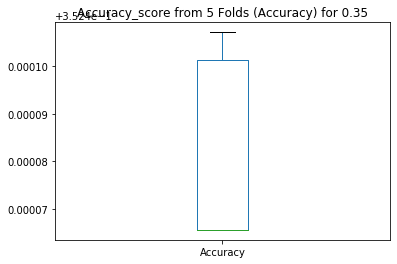

In [18]:
modelNB = MultinomialNB(alpha=1)
modelNB.fit(X_train, y_train)

nfolds=5
scores=cross_val_score(modelNB, X_Training_DS,y_Training_DS, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

y_pred = modelNB.predict(X_test)
print('Accuracy Score : '+str(accuracy_score(y_test,y_pred )*100))

neighbors: 25 Accuracy Score : 0.8805457301667509


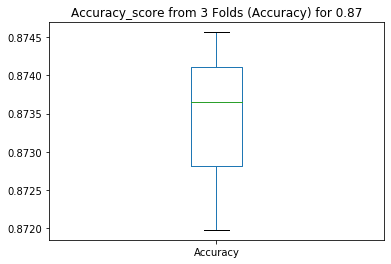

In [19]:
for k in [25]:
    modelKBC = KNeighborsClassifier(n_neighbors=k)
    modelKBC.fit(X_train, y_train)

    y_pred = modelKBC.predict(X_test)
    print('neighbors:',k,'Accuracy Score : '+str(accuracy_score(y_test,y_pred )))

    nfolds=3
    scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
    pd.Series(scores).plot(kind="box", label="Accuracy");
    plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

2020-01-18 19:46:46.799940 Started
2020-01-18 19:46:47.141163 Fit Completed
Accuracy Score : 83.94138453764528
2020-01-18 19:46:47.785400 Completed


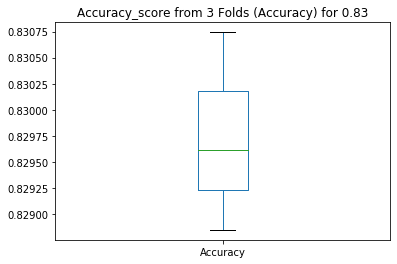

In [20]:
print(str(datetime.datetime.now()),'Started')

modelSVC = svm.LinearSVC(C=0.01)
modelSVC.fit(X_train, y_train)

print(str(datetime.datetime.now()),'Fit Completed')
nfolds=3
scores=cross_val_score(modelSVC, X_train, y_train, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

y_pred = modelSVC.predict(X_test)
print('Accuracy Score : '+str(accuracy_score(y_test,y_pred )*100))

print(str(datetime.datetime.now()),'Completed')

In [21]:
def name_max_value(DF):
    colname='Category_1_Values'
    if (DF['Engineering Sciences']==DF[colname]):
        return 'Engineering Sciences'
    elif (DF['Humanities and Social Sciences']==DF[colname]):
        return 'Humanities and Social Sciences'
    elif (DF['Natural Sciences']==DF[colname]):
        return 'Natural Sciences'
    elif (DF['Life Sciences']==DF[colname]):
        return 'Life Sciences'
    else:
        return ''
    
def name_sec_max_value(DF):
    colname='Category_2_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_1']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_1']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_1']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_1']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
def name_3rd_max_value(DF):
    colname='Category_3_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_2']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_2']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_2']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_2']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''

In [22]:
#matching_category()
cols=['Engineering Sciences','Humanities and Social Sciences','Natural Sciences','Life Sciences']
PredictedValues=pd.DataFrame(modelKBC.predict_proba(merged_data[Features]), columns=cols)
PredictedValues['Category_1_Values']=PredictedValues[cols].apply(np.max,axis=1)
PredictedValues['Category_2_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[2])
PredictedValues['Category_3_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[1])

PredictedValues['Category_1']=PredictedValues.apply(name_max_value,axis=1)
PredictedValues['Category_2']=PredictedValues.apply(name_sec_max_value,axis=1)
PredictedValues['Category_3']=PredictedValues.apply(name_3rd_max_value,axis=1)

PredictedValues['Category_12_Variance']=PredictedValues.apply(lambda x :x['Category_1_Values']-x['Category_2_Values'], axis=1)
PredictedValues['Category_23_Variance']=PredictedValues.apply(lambda x :x['Category_2_Values']-x['Category_3_Values'], axis=1)

In [23]:
PredictedValues.head(16694).tail(5)

,Engineering Sciences,Humanities and Social Sciences,Natural Sciences,Life Sciences,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
16689,0.00,0.00,0.04,0.96,0.96,0.04,0.00,Life Sciences,Natural Sciences,,0.92,0.04
16690,0.00,0.00,0.52,0.48,0.52,0.48,0.00,Natural Sciences,Life Sciences,,0.04,0.48
16691,0.08,0.04,0.52,0.36,0.52,0.36,0.08,Natural Sciences,Life Sciences,Engineering Sciences,0.16,0.28
16692,0.16,0.04,0.56,0.24,0.56,0.24,0.16,Natural Sciences,Life Sciences,Engineering Sciences,0.32,0.08
16693,0.00,0.00,0.96,0.04,0.96,0.04,0.00,Natural Sciences,Life Sciences,,0.92,0.04


In [24]:
NewMergedDSAligned=pd.concat([merged_data[merged_data.columns.tolist()[:12]+['DBScanCluster']],PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)

In [25]:
#(NewMergedDSAligned.DBScanCluster!=0) &

NewMergedDSAligned['DBScanCluster'][ (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

 0    5845
-1     549
Name: DBScanCluster, dtype: int64

In [26]:
NewMergedDSAligned['Category'][(NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

Natural Sciences                  176
Engineering Sciences              161
Life Sciences                     146
Humanities and Social Sciences     66
Name: Category, dtype: int64

In [27]:
cats='Life Sciences'
lim=200
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).head(lim).tail(5)

,Translates,Category,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
30282,The human brain continually compensates for la...,Life Sciences,0.44,0.40,0.16,Humanities and Social Sciences,Engineering Sciences,Life Sciences,0.04,0.24
43526,The morphology of all biological structures is...,Life Sciences,0.44,0.28,0.24,Humanities and Social Sciences,Natural Sciences,Life Sciences,0.16,0.04
34226,The principal goal of a regression analysis is...,Life Sciences,0.40,0.32,0.28,Humanities and Social Sciences,Life Sciences,Natural Sciences,0.08,0.04
38336,The research of this project is based on the f...,Life Sciences,0.40,0.32,0.28,Engineering Sciences,Life Sciences,Natural Sciences,0.08,0.04
43378,Covering less than two percent of the Earth su...,Life Sciences,0.32,0.24,0.24,Natural Sciences,Engineering Sciences,Humanities and Social Sciences,0.08,0.00


In [28]:
#cats='Humanities and Social Sciences'
NewMergedDSAligned[['Translates','Category_1_Values']][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).Translates.head(lim).tail(5).tolist()#.tail().

["The human brain continually compensates for latencies between the senses and between action and perception. The previous project 'ELAPS: Embodied Latency Adaptation and the Perception of Simultaneity' investigated the plasticity of visuomotor delay compensation mechanisms. This is a topic of great relevance for the design and use of digital interfaces (e.g., virtual reality, remote manipulation), where feedback delays are often inevitable. The project results show that humans adapt their motor behavior and time perception to additional feedback delays (sub-second range) given the right circumstances, e.g., a predictable task environment.The continuation proposal 'ELASTiC: Embodied Latencies in Agency, Space, Time and Causation' extends these results with targeted additional experiments for a better understanding of the underlying mechanisms. This work will pay additional attention to the concept of agency (self-initiated action) in the context of visual feedback latencies. The result

In [29]:
#NewMergedDSAligned.to_csv(Path+'WEPCADBScanFindingsKMeans.csv', index=False)

In [99]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

def make_bigram(inputlist):
    bigram = Phrases(inputlist, min_count=1, threshold=1,delimiter=b' ')
    bigram_phraser = Phraser(bigram)
    new_list=[]
    for sent in inputlist:
        new_list.append(bigram_phraser[sent])
    return new_list

def buildLDA(processed_docs, ip_num_topics=4):
    dictionary = gensim.corpora.Dictionary(processed_docs)
    #dictionary.filter_extremes(no_below=1, no_above=0.1, keep_n=1000)
    #dictionary.filter_extremes(no_below=2, no_above=0.1, keep_n=1000)
    #print('Dictionary size', len(dictionary.keys()))
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]

    lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=ip_num_topics, id2word=dictionary, passes=4, workers=4, 
                                                 eta=[0.001]*len(dictionary.keys()), alpha =.005*ip_num_topics)
    
    return dictionary,bow_corpus,corpus_tfidf, lda_model_tfidf

def LDAtopicSummary(model, displaysubplot=[2,2]):
    for idx, topic in model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
        #print('Words: {}'.format(topic))
        
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords',"Text"]
    return(sent_topics_df)

def bestLDAmodel(docs, category):
    catlen=len(category.split(','))-1
    a1=[1,2,3,4,8,10]
    n=len(docs)
    a=list(filter(lambda x:(x<=n)&(x>=catlen), a1))
    if((len(a)==0) and (n<=catlen) ):
        a=list(filter(lambda x:(x<=n), a1))
    modelscore1={}
    modelscore2={}
    modelscore3={}
    modelscore4={}
    
    if(n==1):
        dictionary,bow_corpus,corpus_tfidf, lda_model_tfidf =buildLDA(docs,1)
        coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=docs, dictionary=dictionary, coherence='c_v')
        print('Number of topics',1, 'Coherence Score',round(coherence_model_lda.get_coherence(),2))
        return lda_model_tfidf,bow_corpus,round(coherence_model_lda.get_coherence(),2)
    
    if(len(a)==1):
        dictionary,bow_corpus,corpus_tfidf, lda_model_tfidf =buildLDA(docs,a[0])
        coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=docs, dictionary=dictionary, coherence='c_v')
        print('Number of topics',a[0], 'Coherence Score',round(coherence_model_lda.get_coherence(),2))
        return lda_model_tfidf,bow_corpus,round(coherence_model_lda.get_coherence(),2)
    
    for LDAcount in a:
        dictionary,bow_corpus,corpus_tfidf, lda_model_tfidf =buildLDA(docs , LDAcount)
        coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        modelscore1[LDAcount]=round(coherence_lda,2)
        modelscore2[LDAcount]=lda_model_tfidf
        modelscore3[LDAcount]=bow_corpus
    
    #print(a, modelscore1)
    besttopic=max(modelscore1, key=modelscore1.get)
    print('Number of topics',besttopic, 'Coherence Score', modelscore1[besttopic])
    return modelscore2[besttopic],modelscore3[besttopic],modelscore1[besttopic]
    

In [101]:
df=pd.DataFrame()
for i,w in input_data.groupby(['CategoryCollc']):
    print(i.split(',')[0],'-',i.split(',')[1:],': Number of Documents -',len(w))
    docs=make_bigram(w["PreProcessedDescription"].map(preprocess))
    LDAmodel=bestLDAmodel(docs, i)
    print(LDAtopicSummary(LDAmodel[0]))
    
    df1=format_topics_sentences(LDAmodel[0],LDAmodel[1], w.Translates.tolist())
    df1['OCategory']=i.split(',')[0]
    df1['NCategory']=', '.join(i.split(',')[1:])
    df1['Count']=len(w)
    df=pd.concat([df1,df])
    
    print('\n')
    #break

Engineering Sciences - ['Humanities and Social Sciences'] : Number of Documents - 4
Number of topics 4 Coherence Score 0.69
Topic: 0 Word: 0.045*"metal" + 0.027*"breslauer" + 0.022*"messel" + 0.021*"experience" + 0.021*"experience landscape" + 0.021*"amusement park" + 0.021*"adventure landscape" + 0.019*"bronze" + 0.019*"copper" + 0.019*"fund"
Topic: 1 Word: 0.002*"special" + 0.002*"specific" + 0.002*"single" + 0.002*"sized" + 0.002*"socialist" + 0.002*"spain" + 0.002*"select" + 0.002*"subordinate" + 0.002*"state" + 0.002*"salazar"
Topic: 2 Word: 0.002*"special" + 0.002*"specific" + 0.002*"single" + 0.002*"sized" + 0.002*"socialist" + 0.002*"spain" + 0.002*"select" + 0.002*"subordinate" + 0.002*"state" + 0.002*"salazar"
Topic: 3 Word: 0.155*"urban design" + 0.052*"dictatorship" + 0.039*"spain" + 0.039*"design" + 0.039*"national" + 0.039*"international" + 0.039*"iberian" + 0.039*"field" + 0.026*"development urban" + 0.026*"control urban"
None


Engineering Sciences - ['Humanities and So

Number of topics 3 Coherence Score 0.62
Topic: 0 Word: 0.020*"national socialist" + 0.020*"schultze naumburg" + 0.020*"culture" + 0.020*"region" + 0.017*"network" + 0.017*"housing process" + 0.017*"level" + 0.016*"city" + 0.015*"vision" + 0.015*"rail"
Topic: 1 Word: 0.043*"public" + 0.043*"mass medium" + 0.038*"digital medium" + 0.037*"political" + 0.037*"conflict" + 0.029*"educational contexts" + 0.029*"interactive digital" + 0.025*"medium" + 0.019*"realize potential" + 0.019*"active learning"
Topic: 2 Word: 0.052*"traffic" + 0.032*"question" + 0.026*"traffic emission" + 0.026*"environmental justice" + 0.026*"socio economic" + 0.026*"finding" + 0.026*"impact" + 0.026*"group" + 0.026*"household" + 0.024*"environmental"
None


Engineering Sciences - ['Humanities and Social Sciences', 'Natural Sciences', 'Engineering Sciences'] : Number of Documents - 3
Number of topics 3 Coherence Score 0.54
Topic: 0 Word: 0.048*"action" + 0.039*"drainage" + 0.039*"oderbruch" + 0.034*"adaptation" + 0.02

Number of topics 3 Coherence Score 0.51
Topic: 0 Word: 0.060*"language" + 0.049*"haplotype" + 0.039*"assumption" + 0.020*"phonetic transcription" + 0.020*"studied language" + 0.020*"translation" + 0.020*"major" + 0.020*"problem" + 0.020*"individual" + 0.020*"variation sequence"
Topic: 1 Word: 0.003*"carefully" + 0.003*"broadcastsre" + 0.003*"corpora" + 0.003*"cooperation" + 0.003*"consortium" + 0.003*"community" + 0.003*"communities" + 0.003*"collect" + 0.003*"course" + 0.003*"bulb"
Topic: 2 Word: 0.115*"nirs" + 0.064*"activation" + 0.051*"cmro" + 0.051*"fmri" + 0.038*"neuronal activity" + 0.038*"functional" + 0.025*"vascular response" + 0.025*"experiment" + 0.025*"response" + 0.025*"activate"
None


Engineering Sciences - ['Life Sciences', 'Natural Sciences'] : Number of Documents - 9
Number of topics 8 Coherence Score 0.65
Topic: 0 Word: 0.031*"differentiation" + 0.025*"membrane" + 0.019*"overlap" + 0.018*"silaffin" + 0.018*"lcpa" + 0.018*"impact" + 0.014*"orphan" + 0.014*"determine"

Number of topics 2 Coherence Score 0.68
Topic: 0 Word: 0.005*"heterogenize" + 0.005*"grubbs" + 0.005*"highly" + 0.005*"highlight" + 0.005*"high" + 0.005*"illustrate" + 0.005*"heterogeneous" + 0.005*"goal" + 0.005*"greatly" + 0.005*"importantly"
Topic: 1 Word: 0.063*"catalyst" + 0.043*"chemical" + 0.032*"method" + 0.032*"technique" + 0.032*"develop" + 0.032*"runtime" + 0.027*"follow" + 0.022*"chemical programming" + 0.022*"mechanism" + 0.022*"apoptosis"
None


Engineering Sciences - ['Natural Sciences', 'Life Sciences', 'Engineering Sciences'] : Number of Documents - 1
Number of topics 1 Coherence Score 0.43
Topic: 0 Word: 0.009*"promising" + 0.009*"protein" + 0.009*"produce" + 0.009*"product" + 0.009*"production" + 0.009*"process" + 0.009*"property" + 0.009*"proteins" + 0.009*"protein genetic" + 0.009*"penicillin"
None


Humanities and Social Sciences - ['Engineering Sciences'] : Number of Documents - 2
Number of topics 2 Coherence Score 0.38
Topic: 0 Word: 0.049*"model" + 0.033*"elect

Number of topics 1 Coherence Score 1.0
Topic: 0 Word: 0.013*"network" + 0.013*"monitor" + 0.013*"produce" + 0.013*"potential" + 0.013*"pool" + 0.013*"plant" + 0.013*"particular" + 0.013*"network situ" + 0.013*"provider" + 0.013*"multilateral"
None


Humanities and Social Sciences - ['Life Sciences', 'Humanities and Social Sciences'] : Number of Documents - 12
Number of topics 10 Coherence Score 0.63
Topic: 0 Word: 0.062*"stress response" + 0.062*"female male" + 0.043*"stress" + 0.033*"impact" + 0.031*"genotype" + 0.031*"associate stress" + 0.031*"genetic epigenetic" + 0.031*"httlpr" + 0.031*"stress vulnerability" + 0.031*"parameter"
Topic: 1 Word: 0.001*"base" + 0.001*"band" + 0.001*"close" + 0.001*"calculate" + 0.001*"bind" + 0.001*"bayes factor" + 0.001*"bayes" + 0.001*"collaboration" + 0.001*"area" + 0.001*"amplitude"
Topic: 2 Word: 0.073*"child" + 0.073*"cortisol secretion" + 0.044*"genetic effect" + 0.044*"cortisol" + 0.041*"stress" + 0.029*"genetically influence" + 0.029*"environ

Number of topics 2 Coherence Score 0.73
Topic: 0 Word: 0.128*"fruit carbonate" + 0.073*"delta" + 0.055*"proxy" + 0.037*"provide" + 0.037*"early" + 0.037*"grow" + 0.037*"relationship" + 0.037*"establish" + 0.037*"research" + 0.037*"project"
Topic: 1 Word: 0.118*"bone" + 0.071*"drift" + 0.071*"formation" + 0.070*"model" + 0.047*"advantage" + 0.047*"maggiano" + 0.046*"long bone" + 0.046*"lamellar" + 0.046*"adaptation" + 0.046*"skeletal"
None


Humanities and Social Sciences - ['Natural Sciences', 'Life Sciences', 'Humanities and Social Sciences'] : Number of Documents - 1
Number of topics 1 Coherence Score 0.26
Topic: 0 Word: 0.008*"neglect" + 0.008*"number" + 0.008*"model" + 0.008*"modeling" + 0.008*"necessary" + 0.008*"need" + 0.008*"measure" + 0.008*"neglecting" + 0.008*"optimization" + 0.008*"olivine"
None


Life Sciences - ['Engineering Sciences'] : Number of Documents - 3
Number of topics 3 Coherence Score 0.96
Topic: 0 Word: 0.162*"distribution" + 0.081*"nozzle" + 0.061*"spray" + 0

Number of topics 2 Coherence Score 0.75
Topic: 0 Word: 0.079*"image" + 0.079*"collection" + 0.079*"software" + 0.059*"standard" + 0.059*"object" + 0.059*"metadata" + 0.059*"plant" + 0.040*"data" + 0.040*"million" + 0.040*"document"
Topic: 1 Word: 0.079*"quality" + 0.059*"analysis" + 0.059*"hospital" + 0.049*"patient" + 0.049*"care" + 0.030*"efficiency" + 0.030*"quality care" + 0.030*"subproject" + 0.030*"research" + 0.030*"user"
None


Life Sciences - ['Humanities and Social Sciences', 'Engineering Sciences', 'Natural Sciences'] : Number of Documents - 3
Number of topics 3 Coherence Score 0.95
Topic: 0 Word: 0.119*"online" + 0.080*"price" + 0.060*"retailer" + 0.060*"digitalization" + 0.060*"retailing" + 0.040*"price adjustment" + 0.040*"pricing" + 0.040*"price setting" + 0.040*"food sector" + 0.040*"consumer"
Topic: 1 Word: 0.053*"population" + 0.040*"traffic route" + 0.040*"traffic" + 0.027*"specie" + 0.027*"different" + 0.027*"cross aids" + 0.027*"compare" + 0.027*"isolation" + 0.027

Number of topics 1 Coherence Score 0.53
Topic: 0 Word: 0.009*"phylogeny" + 0.009*"phylogeography" + 0.009*"period glaciation" + 0.009*"permanent" + 0.009*"persistence" + 0.009*"phase" + 0.009*"particular" + 0.009*"proxy" + 0.009*"preparation" + 0.009*"paleoecology"
None


Life Sciences - ['Natural Sciences', 'Life Sciences'] : Number of Documents - 17
Number of topics 3 Coherence Score 0.67
Topic: 0 Word: 0.010*"exoplanet" + 0.009*"spider" + 0.009*"physics" + 0.008*"earth" + 0.008*"thread" + 0.008*"planet" + 0.008*"active passive" + 0.007*"rydberg" + 0.007*"search" + 0.007*"capture thread"
Topic: 1 Word: 0.014*"fish" + 0.013*"ecosystem scale" + 0.012*"association" + 0.012*"oxide" + 0.011*"flux" + 0.011*"enzyme" + 0.011*"measurement" + 0.010*"rhizosphere" + 0.010*"organo mineral" + 0.009*"climate"
Topic: 2 Word: 0.047*"coral" + 0.047*"octocoral" + 0.047*"aragonitic" + 0.035*"skeleton" + 0.035*"polymorph" + 0.035*"protein" + 0.035*"calcite" + 0.035*"target specie" + 0.024*"datum coral" +

Number of topics 2 Coherence Score 0.88
Topic: 0 Word: 0.051*"retrieval" + 0.051*"train" + 0.051*"pulse" + 0.051*"problem" + 0.038*"reconstruction" + 0.038*"method" + 0.038*"development" + 0.038*"regularization" + 0.038*"mathematical" + 0.038*"propose"
Topic: 1 Word: 0.046*"stability" + 0.046*"layer" + 0.034*"cartilage" + 0.034*"structure" + 0.034*"form" + 0.034*"lipid layer" + 0.034*"effect" + 0.023*"focus" + 0.023*"friction" + 0.023*"surface"
None


Natural Sciences - ['Engineering Sciences', 'Natural Sciences'] : Number of Documents - 22
Number of topics 2 Coherence Score 0.52
Topic: 0 Word: 0.015*"crater" + 0.012*"strain" + 0.012*"background knowledge" + 0.009*"geometry description" + 0.008*"target" + 0.007*"npau" + 0.006*"important problem" + 0.006*"model extract" + 0.006*"procedure reduce" + 0.006*"order update"
Topic: 1 Word: 0.006*"power grid" + 0.006*"flow" + 0.006*"hydrofracture" + 0.006*"method" + 0.005*"surface" + 0.005*"binder" + 0.005*"addition" + 0.005*"solution" + 0.005

Number of topics 3 Coherence Score 0.71
Topic: 0 Word: 0.117*"datum" + 0.116*"topic" + 0.077*"endpoint" + 0.077*"multivariate" + 0.059*"multivariate datum" + 0.058*"inference method" + 0.057*"assumption" + 0.057*"test" + 0.056*"high dimensional" + 0.004*"possibly"
Topic: 1 Word: 0.039*"housing" + 0.026*"social capital" + 0.021*"food" + 0.021*"value chain" + 0.020*"network" + 0.018*"transocap" + 0.017*"debate" + 0.017*"domestic" + 0.016*"housing movement" + 0.014*"market"
Topic: 2 Word: 0.097*"calibration" + 0.081*"option" + 0.081*"risk" + 0.065*"lead" + 0.065*"error" + 0.049*"derivative" + 0.032*"quantitative method" + 0.032*"major" + 0.032*"parameter" + 0.032*"rate"
None


Natural Sciences - ['Life Sciences'] : Number of Documents - 11
Number of topics 8 Coherence Score 0.71
Topic: 0 Word: 0.001*"complex" + 0.001*"commonly" + 0.001*"contribute" + 0.001*"contain" + 0.001*"consumption" + 0.001*"concentrated" + 0.001*"deficiency" + 0.001*"carotenoid" + 0.001*"carrot" + 0.001*"different a

Number of topics 8 Coherence Score 0.62
Topic: 0 Word: 0.063*"caco" + 0.062*"calcite" + 0.049*"coccolithophore" + 0.049*"coccolith" + 0.037*"coccolith calcite" + 0.037*"biogenic" + 0.037*"morphogenesis" + 0.027*"organic" + 0.027*"crystal" + 0.025*"point"
Topic: 1 Word: 0.055*"rainfall runoff" + 0.037*"flux" + 0.037*"sense" + 0.037*"respect" + 0.037*"gradient" + 0.037*"subsurface" + 0.031*"potential" + 0.028*"mass" + 0.028*"free energy" + 0.028*"imply"
Topic: 2 Word: 0.035*"physics" + 0.033*"life" + 0.032*"tissue" + 0.030*"matter" + 0.025*"adaptation" + 0.025*"vertebrate" + 0.025*"live" + 0.025*"biology" + 0.018*"schrödinger" + 0.018*"molecule cell"
Topic: 3 Word: 0.031*"rhizosphere" + 0.029*"fiber" + 0.029*"metabolite" + 0.021*"binder" + 0.021*"module" + 0.021*"dietary fiber" + 0.018*"mucilage" + 0.018*"tool" + 0.017*"groove" + 0.017*"base pair"
Topic: 4 Word: 0.001*"coccolith" + 0.001*"coccolithophore" + 0.001*"calcite" + 0.001*"caco" + 0.001*"crystalline" + 0.001*"morphogenesis" + 0.

In [36]:
#&(NewMergedDSAligned['Category']==cats) &(NewMergedDSAligned['Category_1']==check_cat)

input_data=NewMergedDSAligned[(NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1']) & (NewMergedDSAligned.DBScanCluster!=0) ]

input_data.loc[:,'CategoryCollc']=input_data[['Category','Category_1','Category_2','Category_3']].apply(lambda x:x[0]+','+x[1]+','+x[2]+','+x[3], axis=1)
input_data.loc[:,'CategoryCollc']=input_data['CategoryCollc'].str.strip(",")

/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [37]:

varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varcluster=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')

In [61]:
#varcluster.category.unique()

#features_df.columns
#varcluster[varcluster.Variable.isin(features_df.columns)].category_y.value_counts()
#varcluster.head()

pd.DataFrame(features_df.sum().sort_values(ascending=False)).merge(varcluster, how='left', left_index=True, right_on='Variable')[['Variable', 'cluster_name_y','category_y']]

,Variable,cluster_name_y,category_y
933,tissue,Human & Experiment,Uncategorized
1003,biodiversity,NaN,NaN
135,group,Life Sciences,Life Sciences
311,micro,Engineering Sciences,Engineering Sciences
580,adaptation,Chemistry & Mechanical & Electrical,Uncategorized
1003,fauna,NaN,NaN
1003,mammalian,NaN,NaN
1003,ms,NaN,NaN
1003,transporter,NaN,NaN
1003,pondaung,NaN,NaN


Engineering Sciences - ['Humanities and Social Sciences'] : Number of Documents - 3
          Variable                      category_y
228          urban  Humanities and Social Sciences
284         design            Engineering Sciences
1003        jewish                             NaN
163      community  Humanities and Social Sciences
1003      facility                             NaN
1003      schultze                             NaN
1003      naumburg                             NaN
267   architecture            Engineering Sciences
198       national  Humanities and Social Sciences
847            art  Humanities and Social Sciences
660       building                   Life Sciences
1003  dictatorship                             NaN
768    development                Natural Sciences
1003     socialist                             NaN
161           city  Humanities and Social Sciences
214       research  Humanities and Social Sciences
662          field                   Life Science

----------------------------------------------------------
Engineering Sciences - ['Life Sciences', 'Engineering Sciences', 'Humanities and Social Sciences'] : Number of Documents - 7
         Variable                      category_y
892        sensor  Humanities and Social Sciences
570         water                   Uncategorized
1003          bci                             NaN
1003       speech                             NaN
1003           vr                             NaN
798         model                Natural Sciences
699        motion                   Uncategorized
402        system                Natural Sciences
122        signal                   Life Sciences
3            base                         General
450       patient                   Life Sciences
698        method                   Uncategorized
415   measurement                Natural Sciences
1003     sickness                             NaN
285       develop            Engineering Sciences
790     influenc

        Variable            category_y
402       system      Natural Sciences
662        field         Life Sciences
615       domain         Life Sciences
531   mechanical         Uncategorized
813    reduction      Natural Sciences
496     catalyst         Uncategorized
540      organic         Uncategorized
502      crystal         Uncategorized
1003      bubble                   NaN
434     distance         Life Sciences
698       method         Uncategorized
707      problem         Uncategorized
517         high         Uncategorized
556    structure         Uncategorized
330      process  Engineering Sciences
285      develop  Engineering Sciences
315          new  Engineering Sciences
318        order  Engineering Sciences
3           base               General
40       project               General
----------------------------------------------------------
Engineering Sciences - ['Natural Sciences', 'Life Sciences'] : Number of Documents - 1
        Variable            categor

         Variable                      category_y
904       spatial                Natural Sciences
853       control  Humanities and Social Sciences
798         model                Natural Sciences
836        visual                Natural Sciences
1003   peripheral                             NaN
1003          eye                             NaN
1003       foveal                             NaN
382     frequency                Natural Sciences
24    information                         General
537      movement                   Uncategorized
517          high                   Uncategorized
1003         gaze                             NaN
790     influence                Natural Sciences
1003     fixation                             NaN
1003    filtering                             NaN
1003     duration                             NaN
1003        scene                             NaN
1003   contingent                             NaN
1003        fovea                             NaN


         Variable                      category_y
24    information                         General
529    management                   Uncategorized
314          need            Engineering Sciences
341      software            Engineering Sciences
1003          cio                             NaN
711         shall                   Uncategorized
1003     hospital                             NaN
345          task            Engineering Sciences
60        support                         General
798         model                Natural Sciences
1003        board                             NaN
844       network                Natural Sciences
1003    networked                             NaN
74        present                         General
1003    hospitalâ                             NaN
42        provide                         General
1003    executive                             NaN
921      exchange                   Uncategorized
174     education  Humanities and Social Sciences


       Variable                      category_y
450     patient                   Life Sciences
845       study                Natural Sciences
743    analysis                Natural Sciences
759   cognitive                Natural Sciences
1003       care                             NaN
214    research  Humanities and Social Sciences
40      project                         General
135       group                   Life Sciences
515      health                   Uncategorized
221      social  Humanities and Social Sciences
989      effect                         General
1003     choice                             NaN
954       level                   Uncategorized
467    increase                   Life Sciences
205      policy  Humanities and Social Sciences
534      memory                   Uncategorized
50       result                         General
3          base                         General
402      system                Natural Sciences
1003     weight                         

         Variable                      category_y
621   interaction                   Life Sciences
907       climate                Natural Sciences
498      chemical                   Uncategorized
620       protein                   Life Sciences
402        system                Natural Sciences
755        change                Natural Sciences
214      research  Humanities and Social Sciences
393       quantum                Natural Sciences
989        effect                         General
1003      rydberg                             NaN
853       control  Humanities and Social Sciences
557     substrate                   Uncategorized
845         study                Natural Sciences
228         urban  Humanities and Social Sciences
1003        hsp70                             NaN
1003         tree                             NaN
315           new            Engineering Sciences
662         field                   Life Sciences
770     different                Natural Sciences


            Variable                      category_y
170         conflict  Humanities and Social Sciences
748             body                Natural Sciences
249          discuss  Humanities and Social Sciences
881   representation  Humanities and Social Sciences
1003    geopolitical                             NaN
653          section                   Life Sciences
321             part            Engineering Sciences
74           present                         General
651         function                   Life Sciences
1003         healing                             NaN
203           people  Humanities and Social Sciences
1003      protective                             NaN
139              act                   Life Sciences
250           medium  Humanities and Social Sciences
1003      geopolitic                             NaN
204      perspective  Humanities and Social Sciences
780          examine                Natural Sciences
1003           print                          

        Variable                      category_y
235    knowledge  Humanities and Social Sciences
1003     imprint                             NaN
1003      garlic                             NaN
1003  metabolite                             NaN
1003     vitamin                             NaN
1003   olfactory                             NaN
845        study                Natural Sciences
1003    parasite                             NaN
40       project                         General
1003          ms                             NaN
631         host                   Life Sciences
330      process            Engineering Sciences
1003     odorant                             NaN
325   population            Engineering Sciences
798        model                Natural Sciences
734        datum                   Uncategorized
843   individual                Natural Sciences
1003        odor                             NaN
743     analysis                Natural Sciences
1003        milk    

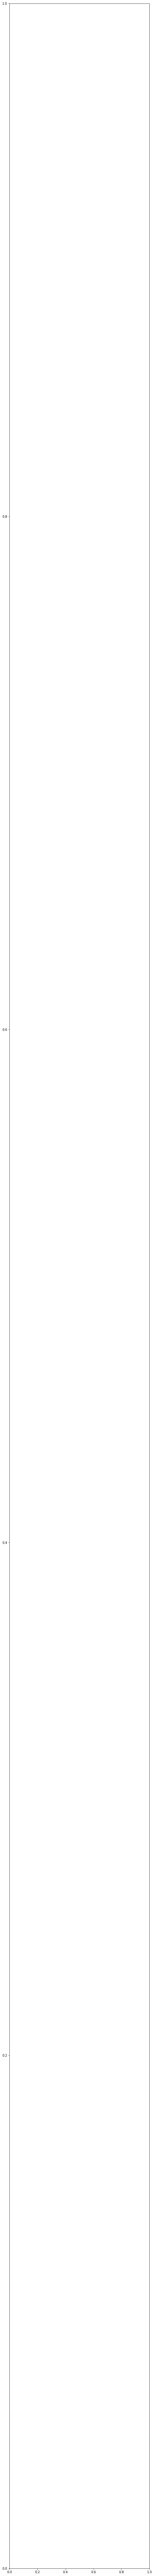

In [65]:
sizes=len(input_data.CategoryCollc.unique())
plt.subplots(figsize=(8,150)) 
j=1

for i,bucket in input_data.groupby(['CategoryCollc']):
    print(i.split(',')[0],'-',i.split(',')[1:],': Number of Documents -',len(bucket))
    
    vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1, 1))
    review_vectors = vectorizer.fit_transform(bucket["PreProcessedDescription"])
    features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

    #print(features_df.sum().sort_values(ascending=False),'\n')
    
    print(pd.DataFrame(features_df.sum().sort_values(ascending=False)).merge(varcluster, how='left', left_index=True, right_on='Variable')[['Variable','category_y']])
    print('----------------------------------------------------------')
    #vectorizer.get_feature_names()
 
    #plt.subplot(1,sizes,j)
    #features_df.sum().sort_values(ascending=False).plot(kind='bar',color='green')
    #plt.title(i.split(',')[0]+' -'+','.join(i.split(',')[1:]))
    #plt.xticks(rotation=60)
    
    #j=j+1
    #plt.tight_layout()

In [85]:
#df.Topic_Keywords.unique().tolist()

for i,w in df.groupby(['OCategory','NCategory']):
    print(i)
    print(w.Topic_Keywords.tolist())
    print('\n')

('Engineering Sciences', 'Humanities and Social Sciences')
['metal, copper, fund, bronze, northern aunetitzer, processing, production, deposit, investigation, prehistoric metal', 'urban design, breslauer, design, messel, experience landscape, experience, amusement park, adventure landscape, dictatorship, class', 'urban design, breslauer, design, messel, experience landscape, experience, amusement park, adventure landscape, dictatorship, class', 'urban design, breslauer, design, messel, experience landscape, experience, amusement park, adventure landscape, dictatorship, class']


('Engineering Sciences', 'Humanities and Social Sciences, Engineering Sciences')
['building facility, berlin, knowledge organization, artificial cognitive, creative, object, human, jewish community, present, facility', 'architectural element, jewish architecture, ship, jewish architectural, east prussia, preserve, jewish, building, brochure, shipbuilding', 'cultural technical, historical building, political dis

# Visualization

In [31]:
def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1


NewMergedDSAligned2=pd.concat([merged_data,PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)

NewMergedDSAligned2.loc[:,'Category_1_ID']=NewMergedDSAligned2.Category_1.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_2_ID']=NewMergedDSAligned2.Category_2.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_3_ID']=NewMergedDSAligned2.Category_3.apply(CattoID)

cats=['Engineering Sciences','Humanities and Social Sciences', 'Life Sciences','Natural Sciences']
cats_dist=[]

## Finiding the overall similiarity

for c, w in NewMergedDSAligned2[(NewMergedDSAligned2['Category']!=NewMergedDSAligned2['Category_1']) & (NewMergedDSAligned2['DBScanCluster']!=1)].groupby('Category'):
    #print('')
    #print(c, len(w))
    #other_cat=list(filter(lambda x:x!=c, cats))
    cat_dist=[]
    for oc in cats:
        if oc==c:
            oc_sim=0
            
        else:
            oc_sum=sum(w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist())
            oc_sim=oc_sum/len(w)
            
        cat_dist.append(oc_sim)
        #print(c,':',oc,'-', round(oc_sim,2))
        
        #oc_sum=w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist()
        #oc_sim=sum(oc_sum)/len(oc_sum)
        #print(c,':',oc,'-', round(oc_sim,2))
    cats_dist.append(np.array(cat_dist))
cats_dist=np.array(cats_dist)

## Making symmetric matrix
sym_dist=np.zeros(cats_dist.shape)
for i in range(cats_dist.shape[0]):
    for j in range(cats_dist.shape[0]):
        sym_dist[i][j]=cats_dist[i][j]+ cats_dist[j][i]
        if(i==j):
            sym_dist[i][j]=1

# 1-x : convert similiarity to distance
sym_dist=1-pd.DataFrame(sym_dist, columns=cats, index=cats)

In [32]:
sym_dist

,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
Engineering Sciences,0.000000,0.647088,0.699223,0.251531
Humanities and Social Sciences,0.647088,0.000000,0.434940,0.727293
Life Sciences,0.699223,0.434940,0.000000,0.306631
Natural Sciences,0.251531,0.727293,0.306631,0.000000


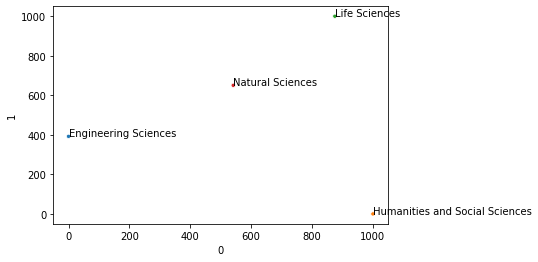

In [88]:
## Generating coordinates from distance

coords = TSNE(n_components=2,perplexity=2, random_state=0, metric='precomputed', angle=0.8).fit_transform(sym_dist)
#coords = TSNE(n_components=2,perplexity=.2, random_state=3, metric='precomputed').fit_transform(sym_dist)
coords=MinMaxScaler([0,1000]).fit_transform(coords)
coords=pd.DataFrame(coords, index=cats).reset_index()
p1=sns.scatterplot(
    x=0, y=1,
    hue="index",
 #   palette=sns.color_palette("hls", 4),
    data=coords,
   # legend="full",
    alpha=1,
    size = 8,
    legend=False
);

for line in range(0,coords.shape[0]):
     p1.text(coords[0][line]+0.01, coords[1][line], cats[line], horizontalalignment='left',  size='medium', color='black')

In [110]:
newrange=pd.DataFrame(NewMergedDSAligned2.Category.value_counts()/80).reset_index().merge(coords,left_on='index',right_on='index')
newrange.loc[:,'Min_X']=newrange[0]-newrange['Category']
newrange.loc[:,'Max_X']=newrange[0]+newrange['Category']
newrange.loc[:,'Min_Y']=newrange[1]-newrange['Category']
newrange.loc[:,'Max_Y']=newrange[1]+newrange['Category']

newrange.columns=['Category','size', 0, 1, 'Min_X', 'Max_X', 'Min_Y', 'Max_Y']
newrange

,Category,size,0,1,Min_X,Max_X,Min_Y,Max_Y
0,Life Sciences,199.433333,874.943970,1000.000000,675.510636,1074.377303,800.566667,1199.433333
1,Natural Sciences,152.488889,541.076660,650.684448,388.587771,693.565549,498.195559,803.173337
2,Humanities and Social Sciences,110.933333,1000.000061,0.000000,889.066728,1110.933394,-110.933333,110.933333
3,Engineering Sciences,104.177778,0.000000,392.368073,-104.177778,104.177778,288.190295,496.545850


In [129]:
catsperplexity={'Engineering Sciences':20,'Humanities and Social Sciences':20, 'Life Sciences':5,'Natural Sciences':40}

## T-SNE separately for each categories

outerclusterfeatures=['Category_1_Values','Category_1_ID','Category_2_ID','Category_2_Values','Category_3_ID','Category_3_Values']
Doc2VecModelData=pd.concat([pd.DataFrame(model.docvecs.vectors_docs),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
    
Doc2VecModelData['tsne-2d-one']=0
Doc2VecModelData['tsne-2d-two']=0

for cat in cats:
    print(str(datetime.datetime.now()),'Started for', cat)
    
    tsne = TSNE(n_components=2, perplexity=catsperplexity[cat], n_iter=300, random_state=0, learning_rate=100)
    tsne_results = tsne.fit_transform(Doc2VecModelData[NewMergedDSAligned2.Category==cat])
    
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-one'] = tsne_results[:,0]
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-two'] = tsne_results[:,1]

    print(str(datetime.datetime.now()),'Completed for', cat)
    

Doc2VecModelData.loc[:,'Category'] = NewMergedDSAligned2.Category

# Reshaping
for cat in cats:
    model_x=MinMaxScaler([newrange[newrange['Category']==cat].Min_X.values[0],newrange[newrange['Category']==cat].Max_X.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-one']=model_x.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-one']])

    model_y=MinMaxScaler([newrange[newrange['Category']==cat].Min_Y.values[0],newrange[newrange['Category']==cat].Max_Y.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-two']=model_y.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-two']])


2020-01-18 21:55:02.244931 Started for Engineering Sciences
2020-01-18 21:56:13.095688 Completed for Engineering Sciences
2020-01-18 21:56:13.095875 Started for Humanities and Social Sciences
2020-01-18 21:57:15.859922 Completed for Humanities and Social Sciences
2020-01-18 21:57:15.860094 Started for Life Sciences
2020-01-18 21:59:58.376397 Completed for Life Sciences
2020-01-18 21:59:58.376581 Started for Natural Sciences
2020-01-18 22:01:54.905310 Completed for Natural Sciences


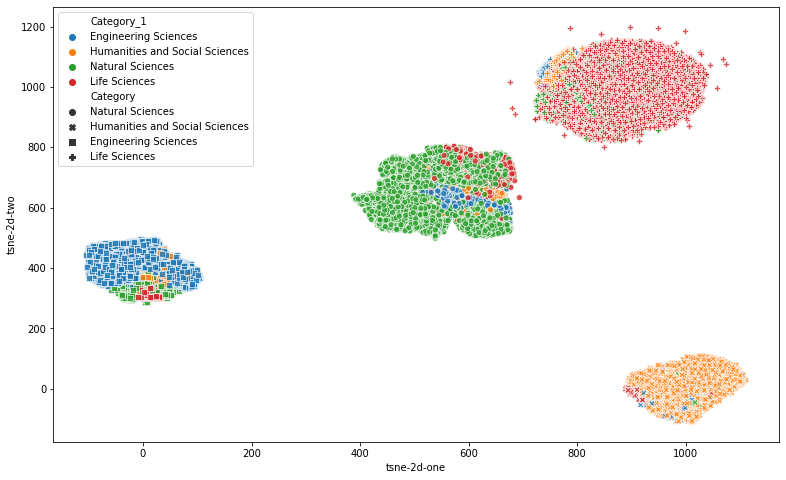

In [131]:
Doc2VecModelData.loc[:,'Category_1'] = NewMergedDSAligned2.Category_1
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData,
        legend="full",
        style='Category',
        alpha=0.8
    );

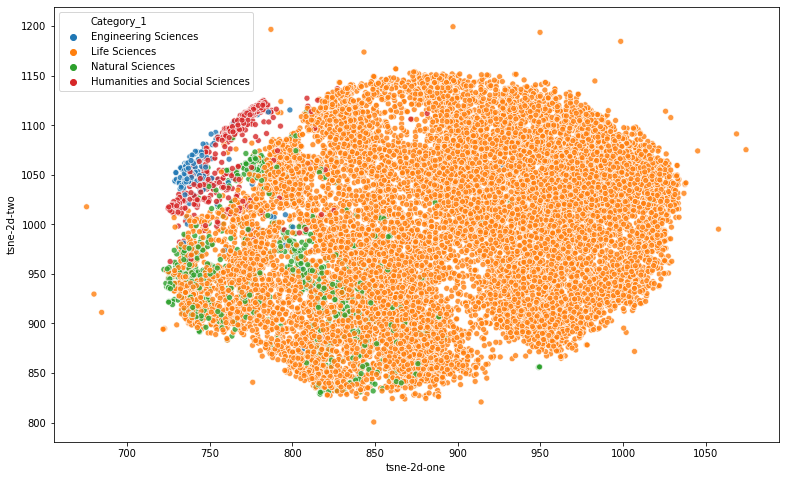

In [132]:

cat='Life Sciences'#'Engineering Sciences'#'Life Sciences'#'Humanities and Social Sciences'#'Life Sciences'#'
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData[Doc2VecModelData.Category==cat],
        legend="full",
#        style='Category_1',
        alpha=0.8
    );

In [133]:
def label_genarator(input):
    if(input.Category==input.Category_1):
        return ''#'Category : '+input.Category
    else:
        if((input.Category_3_Values==0) and (input.Category_2_Values==0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%'+')'
        elif((input.Category_3_Values==0) and (input.Category_2_Values!=0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%)'
        else:
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%, '+input.Category_3+' '+str(round(input.Category_3_Values*100))+'%)'
        
        
Report_extrat=pd.concat([NewMergedDSAligned2[['Name','Institution','FundingFrom','FundingEnd', 'Category','Category_1_Values','Category_2_Values','Category_3_Values','Category_1','Category_2','Category_3']],Doc2VecModelData[['tsne-2d-one', 'tsne-2d-two']]], axis=1)
Report_extrat['label']=Report_extrat.apply(label_genarator, axis=1)
Report_extrat['interdiscipilinary']=False
Report_extrat.loc[(Report_extrat.label!='') & (NewMergedDSAligned2['DBScanCluster']!=0),'interdiscipilinary']=True

In [134]:
Report_extrat.to_csv(Path+'Report_WEPCADBScanFindingsKMeans.csv', index=False)
newrange.to_csv(Path+'CATRANGE_WEPCADBScanFindingsKMeans.csv', index=False)